In [249]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas_datareader.data as web
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [354]:
## Importing SP500 data
tickers = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#:~:text=The%20S%26P%20500%20stock%20market,the%20Dow%20Jones%20Industrial%20Average).")[0]["Symbol"]

for ticker in tickers[1:2]:
    start = dt.datetime(2012, 1, 1)
    end = dt.datetime(2022, 1, 1)
    data = yf.download(ticker, interval="1d")
    data = data.loc[:,["Open","High","Low", "Close", "Volume"]]
    data["Pre_close"] = data.loc[:, "Close"].shift(1)
    data = data.dropna()
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Pre_close
Date,,,,,,
1983-10-03,0.000000,1.090278,1.076389,1.083333,18000,1.083333
1983-10-04,0.000000,1.076389,1.069444,1.069444,21600,1.083333
1983-10-05,0.000000,1.062500,0.944444,0.944444,127800,1.069444
1983-10-06,0.000000,0.965278,0.937500,0.965278,118800,0.944444
1983-10-07,0.000000,0.958333,0.951389,0.951389,37800,0.965278
...,...,...,...,...,...,...
2023-03-03,67.849998,68.190002,66.540001,68.129997,826100,67.639999
2023-03-06,68.139999,68.239998,66.610001,66.900002,1004100,68.129997
2023-03-07,66.779999,67.339996,66.349998,66.389999,854400,66.900002


In [355]:
# Fit model into regression

X = data.drop(["Close"], axis=1).values
y = data["Close"]

num = 1250

X_train = X[:-1*num]
y_train = y[:-1*num]
X_test = X[-1*num:]
y_test = y[-1*num:]

model = LinearRegression()
model = model.fit(X_train, y_train)
predictions = model.predict(X_test)


In [356]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8690, 5) (1250, 5) (8690,) (1250,)


## Evaluting our model

* Root mean square error (RMSE) is the standard deviation of the residuals. The lower the value of RMSE, the better the performance.
* R Square is a good measure to determine how well the model fits the dependent variables. The maximum value is 1.0, the higher the R square, the better the model fit
* Mean Square Error is an absolute measure of the fit of model, it’s result gives us how much deviation from actual number. The lower the MSE value, the higher the prediction accuracy.

In [375]:
# evaluate model with RMSE, R2 and MSE

print("Mean Sqaured Error:", round(metrics.mean_squared_error(y_test, predictions), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predictions), 4))

Mean Sqaured Error: 0.2025
Root Mean Squared Error: 0.45
(R^2) Score: 0.9982


In [358]:
# SMA Indicators

data["5SMA"] = data["Pre_close"].rolling(5).mean()
data["10SMA"] = data["Pre_close"].rolling(10).mean()
data["20SMA"] = data["Pre_close"].rolling(20).mean()
data["50SMA"] = data["Pre_close"].rolling(50).mean()
data["100SMA"] = data["Pre_close"].rolling(100).mean()
data["200SMA"] = data["Pre_close"].rolling(200).mean()

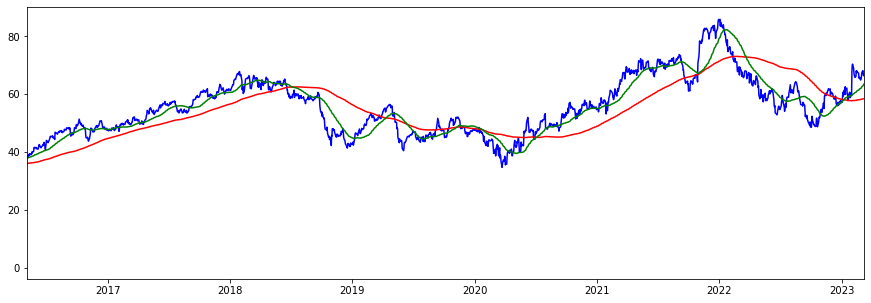

In [359]:
# plot SMA against stock data

plt.figure(figsize=(15,5))
plt.plot(data.index , data["Pre_close"], color="blue")
plt.plot(data.index, data["200SMA"], color="red")
plt.plot(data.index, data["50SMA"], color="green")
plt.xlim([max(data.index) - dt.timedelta(days=2500),
              max(data.index)])

plt.show()

# We can see the general trend of the sp500 price across the years
# With 50 SMA, the trend will follow closer to the price, when 50SMA is above 200 SMA, indicates the start of a long-term uptrend

In [360]:
#EMA indicators

# ema for period = 12
def cal_macd (data, len1, len2, len3):
    short = data["Pre_close"].ewm(span=len1,adjust=False, min_periods=len1).mean()
# ema for period = 26
    long = data["Pre_close"].ewm(span=len2, adjust=False, min_periods=len2).mean()
# calculate Macd
    macd = short - long
    macd_s = macd.ewm(span=len3, adjust=False, min_periods=len3).mean()
    
    return macd, macd_s

In [361]:
Macd, signal = cal_macd(data, 12, 26, 9)
data["Macd"] = Macd
data["Signal"] = signal

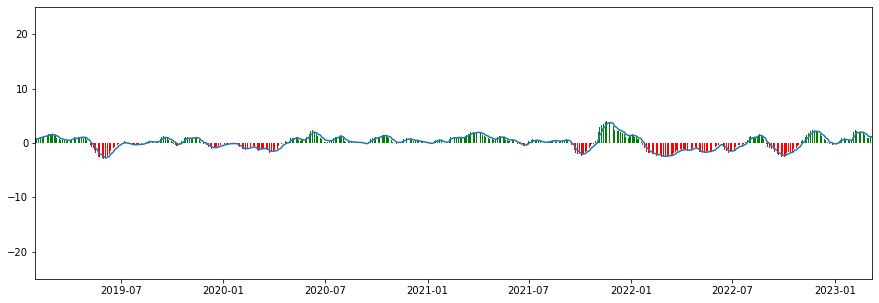

In [362]:
#plot MACD and the signal

plt.figure(figsize=(15,5))

colors = np.where(data['Macd'] < 0, 'red', 'Green')
plt.bar(data.index, data["Macd"],color=colors)
plt.plot(data.index, data["Signal"])
plt.xlim([max(data.index) - dt.timedelta(days=1500), max(data.index)])
plt.ylim(-25, 25)
plt.show()

In [363]:
## RSI indicator
## Will tell us whether a stock is overbought or oversold

def rsi(data, periods, ema = True):
    
    delta = data.diff()
    
    # Make two series: one for lower closes and one for higher closes
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=False).mean()
    ma_down = down.ewm(com = periods - 1, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [364]:
data["RSI"] = rsi(data["Pre_close"], 14)

In [365]:
data = data.fillna(0)

In [366]:
model = LinearRegression()

X = data.drop(["Close"], axis=1).values
y = data["Close"]

num = 1250

X_train = X[:-1*num]
y_train = y[:-1*num]
X_test = X[-1*num:]
y_test = y[-1*num:]

model = model.fit(X_train, y_train)
preds = model.predict(X_test)

In [367]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8690, 14) (1250, 14) (8690,) (1250,)


In [376]:
print("Mean Sqaured Error:", round(metrics.mean_squared_error(y_test, preds), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, preds)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, preds), 4))

Mean Sqaured Error: 0.2107
Root Mean Squared Error: 0.4591
(R^2) Score: 0.9981


In [377]:
#Create a new dataframe with the predicted values
df = pd.DataFrame({'Close': X_test.T[0], 'Predicted_values': preds}, index=y_test.index)

In [378]:
#long term strategy

def buy_sell(data, initial_balance=2000):
    
    # Compute the 20-day and 100-day Simple Moving Averages
    data["20SMA"] = data["Predicted_values"].rolling(20).mean()
    data["100SMA"] = data["Predicted_values"].rolling(100).mean()
    
    # Assign 1/0 to the "signal" column based on the comparison of the 20-day and 100-day Simple Moving Averages.
    # If 20SMA > 100 SMA, it will be 1, else it is 0
    data["signal"] = np.where(data["20SMA"] > data["100SMA"], 1, 0)
    
    # This ensures that the code only executes a single buy trade at the beginning of the trend and 
    # a single sell trade at the end of the trend. The "position" column is obtained by taking the difference 
    # between consecutive "signal" values.
    data["position"] = data["signal"].diff()
    
    # Extract the close price that correspond to the "position" column 
    buy_signal = data[data["position"] == 1]["Close"]
    sell_signal = data[data["position"] == -1]["Close"]
    
    account = initial_balance
    shares = 0
    
    for i in range(len(buy_signal)):
        if i == 0:
            continue
        buy_price = buy_signal[i]
        sell_price = sell_signal[i-1]
        shares_to_buy = account // buy_price
        shares += shares_to_buy
        account -= shares_to_buy * buy_price
        account += shares * sell_price
        shares = 0
    
    fig, ax = plt.subplots(figsize=(18,10))
    
    # Plot the predicted values, 20-day SMA, and 100-day SMA
    ax.plot(data['Predicted_values'],label=f"{ticker} Closing Price", linewidth=0.75, color='blue', alpha=0.9)
    ax.plot(data['20SMA'], label='20SMA', alpha=0.85)
    ax.plot(data['100SMA'], label='100SMA', alpha=0.85)
    
    # Plot the buy and sell signals
    ax.scatter(buy_signal.index, buy_signal, label='Buy', marker='^', color='green', alpha=1)
    ax.scatter(sell_signal.index, sell_signal, label='Sell', marker='v', color='red', alpha=1)
    
    ax.set_title(f"{ticker} Closing Price History with signals", fontsize=18)
    ax.set_xlabel("Date", fontsize=18)
    ax.set_ylabel('Close Price', fontsize=18)
    
    legend = ax.legend()
    ax.grid(linewidth=0.75, linestyle="--")
    plt.tight_layout()
    plt.show()
    
    print(f"Initial balance: {initial_balance}")
    print(f"Final balance: {account}")
    print(f"Profit/Loss: {account-initial_balance}")

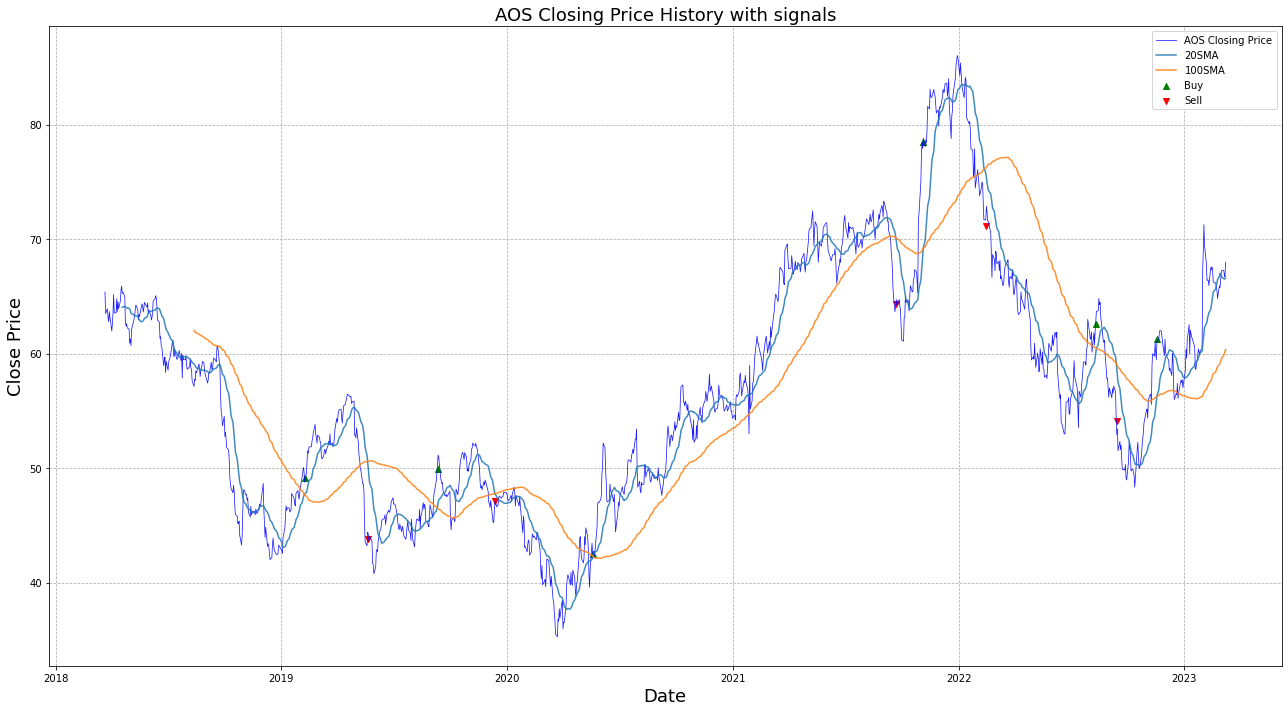

Initial balance: 2000
Final balance: 1612.4401321411133
Profit/Loss: -387.5598678588867


In [379]:
buy_sell(df, initial_balance=2000)

In [380]:
#Short term strategy

def buy_sell(data, initial_balance=2000):
    
    data["20SMA"] = data["Predicted_values"].rolling(20).mean()
    data["signal"] = np.where(data["Predicted_values"] > data["20SMA"], 1, -1)
    data["position"] = data["signal"].diff()
    
    buy_signal = data[data["position"] == 2]["Close"]
    sell_signal = data[data["position"] == -2]["Close"]
    
    account = initial_balance
    shares = 0
    
    for i in range(len(buy_signal)):
        if i == 0:
            continue
        
        # Buy at the current buy signal price
        buy_price = buy_signal[i]
        
        # Sell at the previous sell signal price (if applicable)
        sell_price = sell_signal[i-1]
        
        shares_to_buy = account // buy_price
        shares += shares_to_buy
        account -= shares_to_buy * buy_price
        account += shares * sell_price
        shares = 0
    
    fig, ax = plt.subplots(figsize=(18,10))
    
    ax.plot(data['Predicted_values'], label=f"{ticker} Closing Price", linewidth=0.75, color='blue', alpha=0.9)
    ax.plot(data['20SMA'], label='20SMA', alpha=0.85)
    
    ax.scatter(buy_signal.index, buy_signal, label='Buy', marker='^', color='green', alpha=1)
    ax.scatter(sell_signal.index, sell_signal, label='Sell', marker='v', color='red', alpha=1)
    
    ax.set_title(f"{ticker} Closing Price History with signals", fontsize=18)
    ax.set_xlabel("Date", fontsize=18)
    ax.set_ylabel('Close Price', fontsize=18)
    ax.set_xlim([max(data.index) - dt.timedelta(days=1095),
              max(data.index)])
    
    legend = ax.legend()
    plt.grid(linewidth=0.75, linestyle="--")
    plt.tight_layout()
    plt.show()
    
    # Print final account balance and profit/loss
    print(f"Initial balance: ${initial_balance}")
    print(f"Final balance: ${account}")
    print(f"Profit/Loss: ${account-initial_balance}")
    

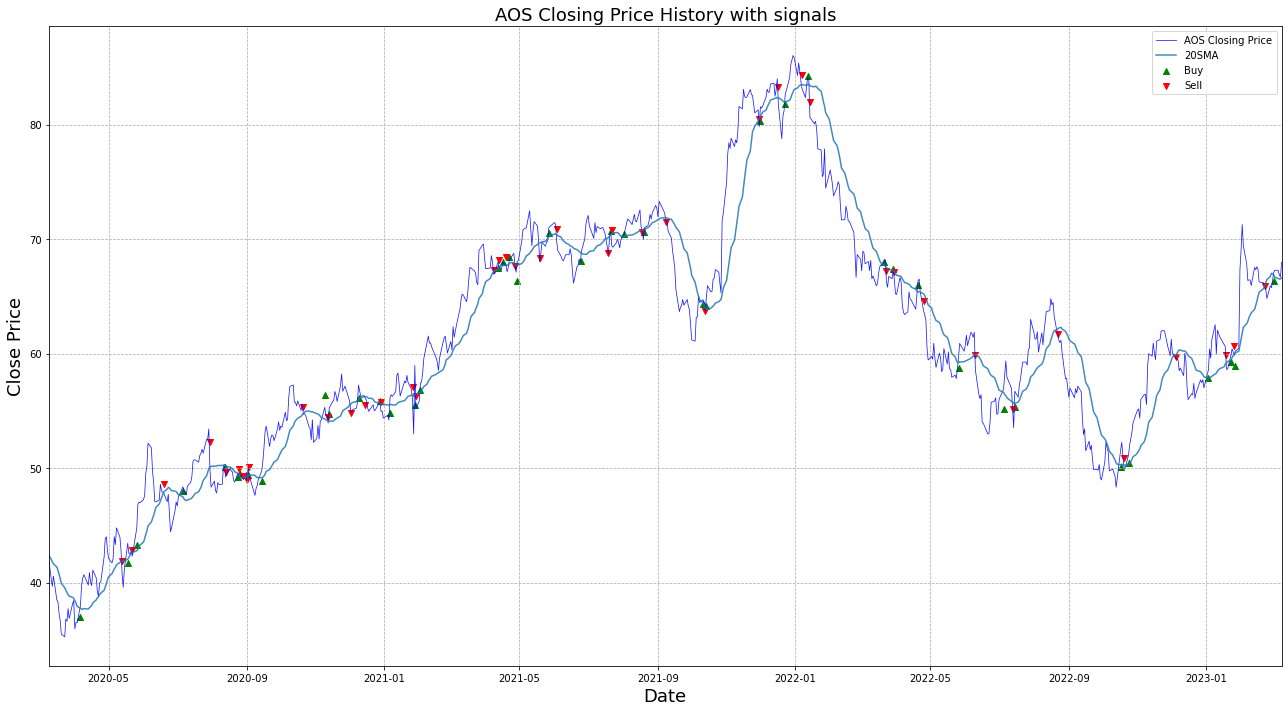

Initial balance: $2000
Final balance: $12272.819747924805
Profit/Loss: $10272.819747924805


In [381]:
buy_sell(df, initial_balance=2000)

In [396]:
def MACD_Strategy(data, initial_balance=2000):
    
    shortEMA = data["Predicted_values"].ewm(span=12, adjust=False).mean()
    longEMA = data["Predicted_values"].ewm(span=26, adjust=False).mean()
    
    MACD = shortEMA - longEMA
    signal = MACD.ewm(span=9, adjust=False).mean()
    MACDh = MACD - signal

    buy_signals = []
    sell_signals = []
    position = False
    account = initial_balance
    shares = 0

    # Loop through each data point
    for i in range(len(data["Predicted_values"])):
        
        # If the MACD line crosses above the signal line and we're not already in a long position, buy the stock
        if MACD[i] > signal[i] and not position:
            buy_signals.append(data["Close"][i])
            shares_to_buy = account // data["Close"][i]
            shares += shares_to_buy
            account -= shares_to_buy * data["Close"][i]
            position = True
            sell_signals.append(np.nan)
        
        # If the MACD line crosses below the signal line and we're currently in a long position, sell the stock
        elif MACD[i] < signal[i] and position:
            sell_signals.append(data["Close"][i])
            account += shares * data["Close"][i]
            shares = 0
            position = False
            buy_signals.append(np.nan)
        
        # If there is no crossover, append NaN to both the buy and sell signals lists, allows us to plot discrete points
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)
    
    # Add the buy and sell signals to the data DataFrame
    data['Macd_Buy'] = buy_signals
    data['Macd_Sell'] = sell_signals
    
    # Add the MACD and signal lines, as well as the MACD histogram, to the data DataFrame
    data["MACD"] = MACD
    data["MACDs"] = signal
    data["MACDh"] = MACDh
    
    # Create a new figure with 2 subplots
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
    
    ax1.plot('Close', data=data, label='Close Price', linewidth=0.5, color='blue')
    ax1.scatter(data.index, data['Macd_Buy'], label='Buy', color='green', marker='^', alpha=1)
    ax1.scatter(data.index, data['Macd_Sell'], label='Sell', color='red', marker='v', alpha=1)
    ax1.set_xlabel('Date', fontsize=8)
    ax1.set_ylabel('Stock Closing Price', fontsize=8)

    ax1.legend()
    ax1.grid()
    

    ax2.plot('MACD', data=data, label='MACD', linewidth=0.5, color='blue')
    ax2.plot('MACDs', data=data, label='signal', linewidth=0.5, color='red')
    ax2.bar(data.index,'MACDh', data=data, label='Histogram', color=np.where(data['MACDh'] < 0, 'red', 'green'), alpha=0.5)
    ax2.set_xlim([data.index.min(), data.index.max()])
    ax2.set_ylabel('MACD', fontsize=8)
    ax2.set_xlabel('Date', fontsize=8)
    ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    plt.show()
    
    print(f"Initial balance: ${initial_balance}")
    print(f"Final balance: ${account}")
    print(f"Profit/Loss: ${account-initial_balance}")

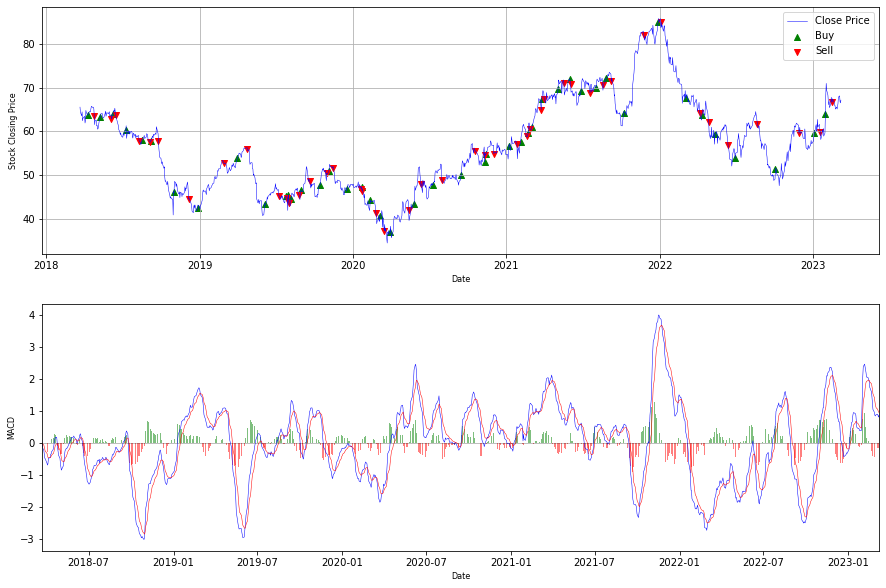

Initial balance: $2000
Final balance: $5584.319198608398
Profit/Loss: $3584.3191986083984


In [397]:
MACD_Strategy(df, initial_balance=2000)